In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split

!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv

bike_data = pd.read_csv('daily-bike-share.csv')
bike_data['day']= pd.DatetimeIndex(bike_data['dteday']).day
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']
bike_data[numeric_features + ['rentals']].describe()
print(bike_data.head(5))

X,y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=0)

print('Training Set: %d rows\nTest set: %d rows' % (X_train.shape[0],X_val.shape[0]))

--2023-11-25 18:14:31--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48800 (48K) [text/plain]
Saving to: 'daily-bike-share.csv.5'

     0K .......... .......... .......... .......... .......   100%  236K=0.2s

2023-11-25 18:14:32 (236 KB/s) - 'daily-bike-share.csv.5' saved [48800/48800]



   instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2011       1   0     1        0        6           0   
1        2  1/2/2011       1   0     1        0        0           0   
2        3  1/3/2011       1   0     1        0        1           1   
3        4  1/4/2011       1   0     1        0        2           1   
4        5  1/5/2011       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  rentals  day  
0           2  0.344167  0.363625  0.805833   0.160446      331    1  
1           2  0.363478  0.353739  0.696087   0.248539      131    2  
2           1  0.196364  0.189405  0.437273   0.248309      120    3  
3           1  0.200000  0.212122  0.590435   0.160296      108    4  
4           1  0.226957  0.229270  0.436957   0.186900       82    5  
Training Set: 511 rows
Test set: 220 rows


mse: 104365.41629226021
rmse: 323.056367051108
r2 score 0.7953981517127191


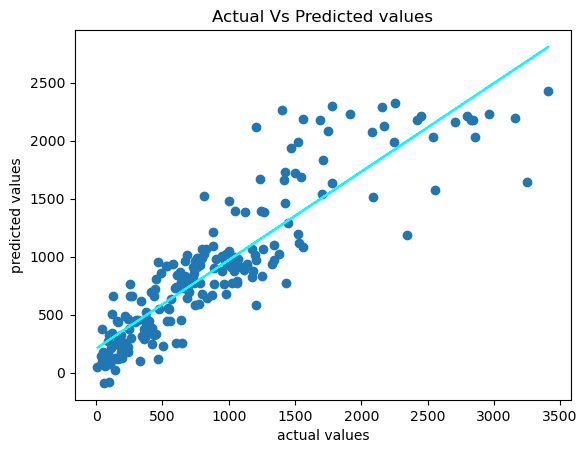

In [5]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

model1 = GradientBoostingRegressor()
model1.fit(X_train,y_train)
prediction1 = model1.predict(X_val)

mse = mean_squared_error(y_val,prediction1)
print('mse:',mse)
rmse = np.sqrt(mse)
print('rmse:',rmse)

r2 = r2_score(y_val,prediction1)
print('r2 score',r2)

plt.scatter(y_val,prediction1)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Actual Vs Predicted values')

z = np.polyfit(y_val,prediction1,1)
p = np.poly1d(z)
plt.plot(y_val,p(y_val),color='cyan')
plt.show()

Optimizing HyperParameters :

How do you know what hyperparameter values you should use? Well, in the absence of a deep understanding of how the underlying algorithm works, you'll need to experiment. Fortunately, SciKit-Learn provides a way to *tune* hyperparameters by trying multiple combinations and finding the best result for a given performance metric.

Let's try using a *grid search* approach to try combinations from a grid of possible values for the **learning_rate** and **n_estimators** hyperparameters of the **GradientBoostingRegressor** estimator.

Best hyperparameter combination: {'learning_rate': 0.1, 'n_estimators': 100} 

mse: 104035.91790377122
rmse: 322.54599347034406
r2 score 0.7960441126228327


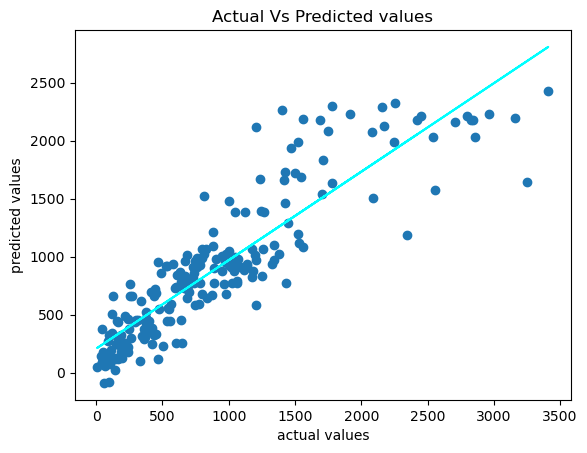

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

algo = GradientBoostingRegressor()

#try these hyperparameter values
params = {
    'learning_rate': [0.1,0.5,1.0],
    'n_estimators':[50,100,150]
}

#find the best hyperparameter combination to optimize the r2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(algo,params,scoring=score,cv=3,return_train_score=True)
gridsearch.fit(X_train,y_train)
print('Best hyperparameter combination:',gridsearch.best_params_,'\n')

#Get the best model
model2 = gridsearch.best_estimator_

#Evaluate the model using the test data
prediction2 = model2.predict(X_val)
mse = mean_squared_error(y_val,prediction2)
print('mse:',mse)
rmse = np.sqrt(mse)
print('rmse:',rmse)

r2 = r2_score(y_val,prediction2)
print('r2 score',r2)

plt.scatter(y_val,prediction2)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Actual Vs Predicted values')

z = np.polyfit(y_val,prediction2,1)
p = np.poly1d(z)
plt.plot(y_val,p(y_val),color='cyan')
plt.show()

Preprocess the Data

We trained a model with data that we loaded straight from a source file, with only moderately successful results.

In practice, it's common to perform some preprocessing of the data to make it easier for the algorithm to fit a model to it.
To apply these preprocessing transformations to the bike rental, we'll make use of a Scikit-Learn feature named *pipelines*. These pipelines allow us to define a set of preprocessing steps that end with an algorithm. You can then fit the entire pipeline to the data, so that the model encapsulates all of the preprocessing steps as well as the regression algorithm.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

# Define preprocessing for numeric columns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps= [
    ('scaler',StandardScaler())])

# Define preprocessing for categorical columns (encode them)

categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers = [
        ('num:',numeric_transformer,numeric_features),
        ('cat:',categorical_transformer,categorical_features)])

#Create preprocessing and training pipelines

pipeline = Pipeline(steps = [ ('preprocessor:',preprocessor),
                              ('regressor:',GradientBoostingRegressor())])

# # fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor:',
                 ColumnTransformer(transformers=[('num:',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat:',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor:', GradientBoostingRegressor())])


mse: 104035.91790377122
rmse: 322.54599347034406
r2 score 0.7916749710535934


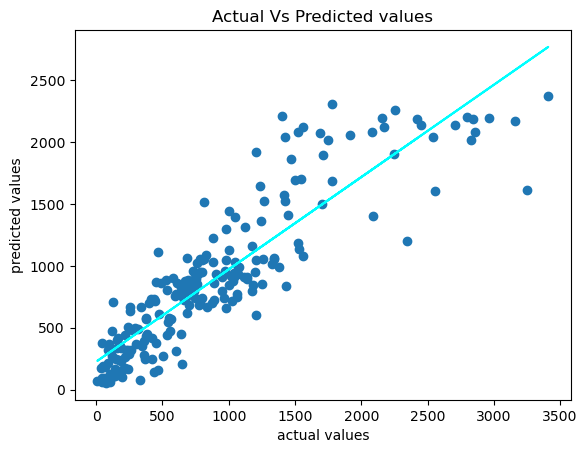

In [13]:

#Evaluate the model using the test data
prediction = model.predict(X_val)
mse = mean_squared_error(y_val,prediction2)
print('mse:',mse)
rmse = np.sqrt(mse)
print('rmse:',rmse)

r2 = r2_score(y_val,prediction)
print('r2 score',r2)

plt.scatter(y_val,prediction)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Actual Vs Predicted values')

z = np.polyfit(y_val,prediction,1)
p = np.poly1d(z)
plt.plot(y_val,p(y_val),color='cyan')
plt.show()

Use the Trained Model

First, let's save the model.

In [14]:
import joblib

filename = './bike-share.pkl'
joblib.dump(model,filename)

['./bike-share.pkl']

Now, we can load it whenever we need it and use it to predict labels for new data. This is often called *scoring* or *inferencing*.

In [16]:
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation
X_new = np.array([[1,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} rentals'.format(np.round(result[0])))

New sample: [1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, 0.22927, 0.436957, 0.1869]
Prediction: 122 rentals


The model's **predict** method accepts an array of observations, so you can use it to generate multiple predictions as a batch.

In [17]:
# An array of features based on five-day weather forecast
X_new = np.array([[0,1,1,0,0,1,0.344167,0.363625,0.805833,0.160446],
                  [0,1,0,1,0,1,0.363478,0.353739,0.696087,0.248539],
                  [0,1,0,2,0,1,0.196364,0.189405,0.437273,0.248309],
                  [0,1,0,3,0,1,0.2,0.212122,0.590435,0.160296],
                  [0,1,0,4,0,1,0.226957,0.22927,0.436957,0.1869]])

# Use the model to predict rentals
results = loaded_model.predict(X_new)
print('5-day rental predictions:')
for prediction in results:
    print(np.round(prediction))

5-day rental predictions:
493.0
929.0
428.0
430.0
491.0


## Summary

This concludes the notebooks for this module on regression. In this notebook, we ran a complex regression, tuned it, saved the model, and used it to predict outcomes for the future.